<h1 style="font-size:44px;font-weight:900">Toxic Comment Classification</h1>

<a id="contents_tabel"></a>

## 📚 Table of Content
<br>

<span style="font-size: 1.2em;line-height:1.5">
    
    
- **[1 | Import Libraries](#l)**
- **[2 | Dataset Overview](#2)**
- **[3 | EDA](#3)** 
    - **[3.1 | Content length across intensities](#3.1)** 
    - **[3.2 | Target's Distribution](#3.2)** 
    - **[3.3 | Top Words](#3.3)** 
- **[4 | Data Preparation](#4)**  
- **[5 | Train-Validation-Test Split](#5)** 
- **[6 | Text Normalization](#5)**
    - **[6.1 | Converting to Lowercase](#6.1)**
    - **[6.2 | Removal of Whitespaces](#6.2)** 
    - **[6.3 | Removal of Punctuations](#6.3)** 
    - **[6.4 | Removal/Handling of Unicode Characters](#6.4)** 
    - **[6.5 | Substitution of Acronyms](#6.5)** 
    - **[6.6 | Substitution of Contractions](#6.6)** 
    - **[6.7 | Slangs and Abbreviations Handling](#6.7)** 
    - **[6.8 | Spelling Correction](#6.8)**
    - **[6.9 | Stemming and Lemmatization](#6.9)** 
    - **[6.10 | Discardment of Non-alphabetic Words](#6.10)** 
    - **[6.11 | Retainment of Relevant Parts of Speech](#6.11)** 
    - **[6.12 | Stop-words Removal](#6.12)** 
    - **[6.13 | Workflow Integration](#6.13)** 
- **[7 | TF-IDF Vectorization](#7)** 
- **[8 | Model Building](#8)** 
- **[9 | Model Evaluation](#9)** 
- **[9 | Testing on NEW Data](#9)** 

<a id="1"></a>
# <p style="background-color:black; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">1 | Import Libraries</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

import warnings
warnings.filterwarnings('ignore')


from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split, ParameterGrid

# Bag-of words
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# BOW 
from sklearn.feature_extraction.text import CountVectorizer

# Classifiers
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score,f1_score,confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV

import string, re, nltk
import emoji # 
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
# !pip install num2words
from num2words import num2words
# !pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer



<a id="2"></a>
# <p style="background-color:black; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">2 | Dataset Overview </p>

⬆️ [Tabel of Contents](#contents_tabel)

In [2]:
# train data
train = pd.read_csv("Datasets/train.csv")
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train.shape

(159571, 8)

In [4]:
train['toxic'].value_counts()

toxic
0    144277
1     15294
Name: count, dtype: int64

In [5]:
# test data without labels
test = pd.read_csv("Datasets/test.csv")
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
# test data labels
test_labels = pd.read_csv("Datasets/test_labels.csv")
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [7]:
test_labels['toxic'].value_counts()

toxic
-1    89186
 0    57888
 1     6090
Name: count, dtype: int64

<div style="background: #CBC3E3;padding:10px;border-radius:12px;border:1px solid #7d1b7e"><p>The target features consist of three values: -1, 0, and 1. To analyze this further, we need to investigate the test data labels. Since this is a binary classification problem, the labels should ideally be 0 or 1. We need to unde</p>

In [8]:
test_labels[test_labels['toxic']==1]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
21,00091c35fa9d0465,1,0,0,0,0,0
48,0013fed3aeae76b7,1,0,1,0,1,1
59,0017d4d47894af05,1,0,1,0,1,0
76,001d739c97bc2ae4,1,0,0,0,0,0
81,001eff4007dbb65b,1,0,1,0,1,0
...,...,...,...,...,...,...,...
152879,ff84f0367ea58abb,1,0,1,0,1,0
152908,ff91c3d8a3e34398,1,0,0,0,1,0
153078,ffdf6854b41d9102,1,0,0,0,0,0
153119,ffebe90c8d5acaba,1,0,1,0,0,0


In [9]:
test[test['id']== '0017d4d47894af05']['comment_text']

59    :Fuck off, you anti-semitic cunt.  |
Name: comment_text, dtype: object

In [10]:
test_labels[test_labels['toxic']==-1]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [11]:
test[test['id']== '00001cee341fdb12']['comment_text']

0    Yo bitch Ja Rule is more succesful then you'll...
Name: comment_text, dtype: object

In [12]:
test[test['id']== 'ffffce3fb183ee80']['comment_text']

153163    " \n :::Stop already. Your bullshit is not wel...
Name: comment_text, dtype: object

<div style="background: #CBC3E3;padding:10px;border-radius:12px;border:1px solid #7d1b7e"><p>After analyzing the data, we observed that labels with values of -1 and 1 appear to represent the same category. This suggests that -1 might be a data entry error or an incorrect label.

<a id="3"></a>
# <p style="background-color:black; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">3 | EDA </p>

⬆️ [Tabel of Contents](#contents_tabel)

<a id="3.1"></a>
  # <b><span style='color:#7d1b7e'>3.1 |</span><span style='color:#ff2c2c'> Content length across intensities</span></b>

In [13]:
train['comment_len'] = train['comment_text'].apply(lambda x: len(x.split(' ')))
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_len
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,42
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,18
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,112
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13


In [14]:
train[train['comment_len'] == 0]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_len


In [15]:
toxic_df = train[train['toxic']==1].copy()
severe_toxic_df = train[train['severe_toxic']==1].copy()
obscene_toxic_df = train[train['obscene']==1].copy()
insult_df = train[train['insult']==1].copy()
identity_hate_df = train[train['identity_hate']==1].copy()
non_toxic_df = train[(train['toxic']==0) & 
                  (train['severe_toxic']==0) & 
                  (train['obscene']==0) & 
                  (train['insult']==0) &
                 (train['identity_hate']==0)].copy()

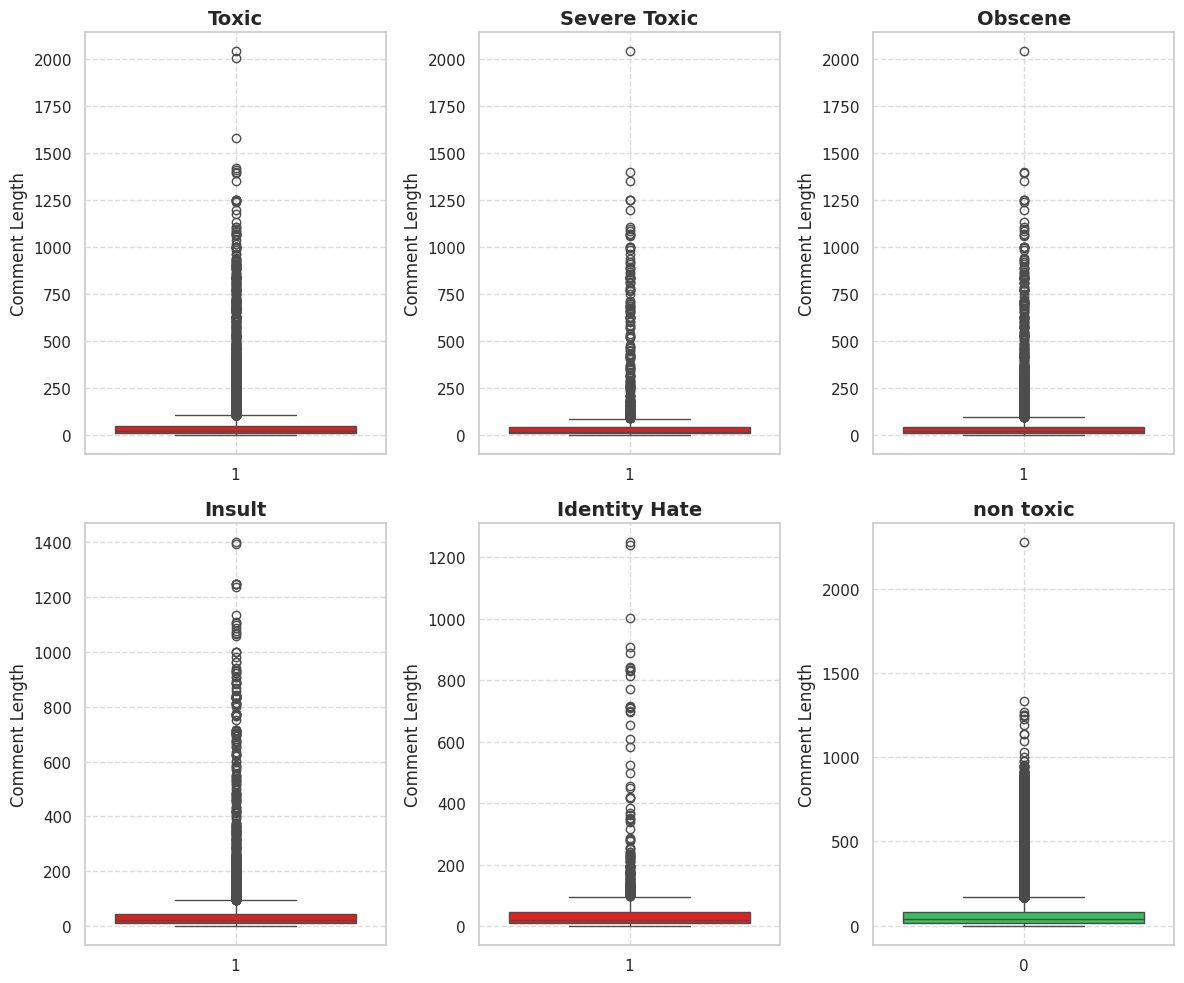

In [16]:
# Set Seaborn style
sns.set(style='whitegrid')

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Define unique colors for each plot
colors = ['red','#1fd655']

# List of dataframes, their corresponding columns, titles, and colors
data_frames = [
    (toxic_df, 'toxic', 'Toxic', colors[0]),
    (severe_toxic_df, 'severe_toxic', 'Severe Toxic', colors[0]),
    (obscene_toxic_df, 'obscene', 'Obscene', colors[0]),
    (insult_df, 'insult', 'Insult', colors[0]),
    (identity_hate_df, 'identity_hate', 'Identity Hate', colors[0]),
    (non_toxic_df, 'toxic', 'non toxic', colors[1]),
]

# Plot each dataframe in a separate subplot
for ax, (df, col, title, color) in zip(axes, data_frames):
    sns.boxplot(x=col, y='comment_len', data=df, ax=ax, color=color)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Comment Length')
    ax.grid(True, linestyle='--', alpha=0.7)  
    
# Hide the last subplot if using a 2x3 grid
for j in range(len(data_frames), len(axes)):
    axes[j].axis('off')
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


<div style="background: #CBC3E3;padding:10px;border-radius:12px;border:1px solid #7d1b7e"><p>we can see that toxic one's are express in longer and more words while non-toxic may be expressed concisely in some cases.

<a id="3.2"></a>
  # <b><span style='color:#7d1b7e'>3.2 |</span><span style='color:#ff2c2c'> Target's Distribution</span></b>

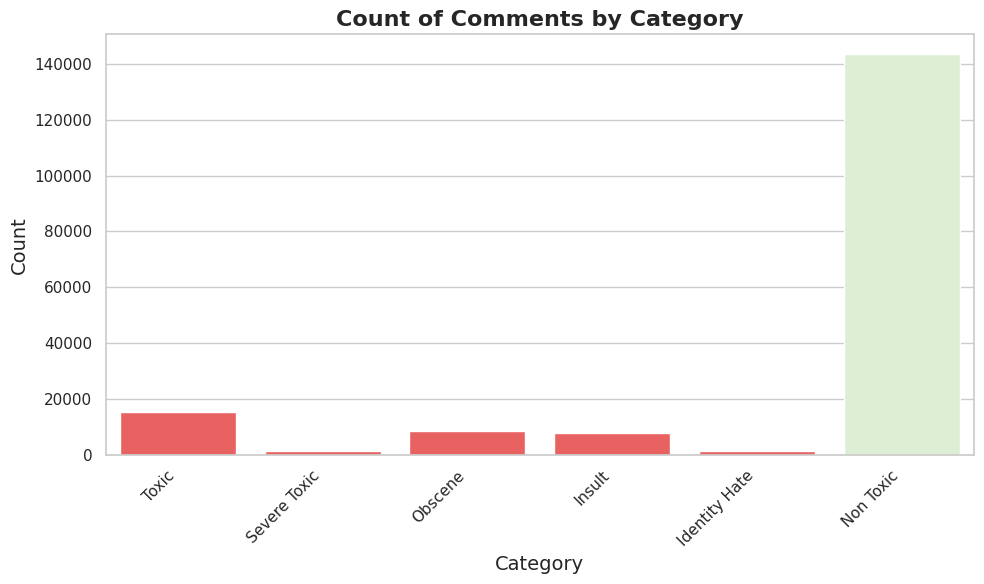

In [17]:
categories = [
    'Toxic', 
    'Severe Toxic', 
    'Obscene', 
    'Insult', 
    'Identity Hate', 
    'Non Toxic'
]

# Corresponding lengths of each dataframe
lengths = [
    len(toxic_df),
    len(severe_toxic_df),
    len(obscene_toxic_df),
    len(insult_df),
    len(identity_hate_df),
    len(non_toxic_df)
]

# Create a DataFrame for plotting
data = pd.DataFrame({
    'Category': categories,
    'Count': lengths
})

# Set Seaborn style
sns.set(style='whitegrid')

# Define colors
colors = ['#ff4c4c'] * 5  # Red color for all categories except Non Toxic
colors.append('#DDF2D1')  # Green color for Non Toxic

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Category', y='Count', data=data, palette=colors)

# Add titles and labels
ax.set_title('Count of Comments by Category', fontsize=16, fontweight='bold')
ax.set_xlabel('Category', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


<div style="background: #CBC3E3;padding:10px;border-radius:12px;border:1px solid #7d1b7e"><p> The dataset contains more categories of <b>non toxic</b> compared to toxic one's</p>

<a id="3.3"></a>
  # <b><span style='color:#7d1b7e'>3.3 |</span><span style='color:#ff2c2c'> Top Words</span></b>

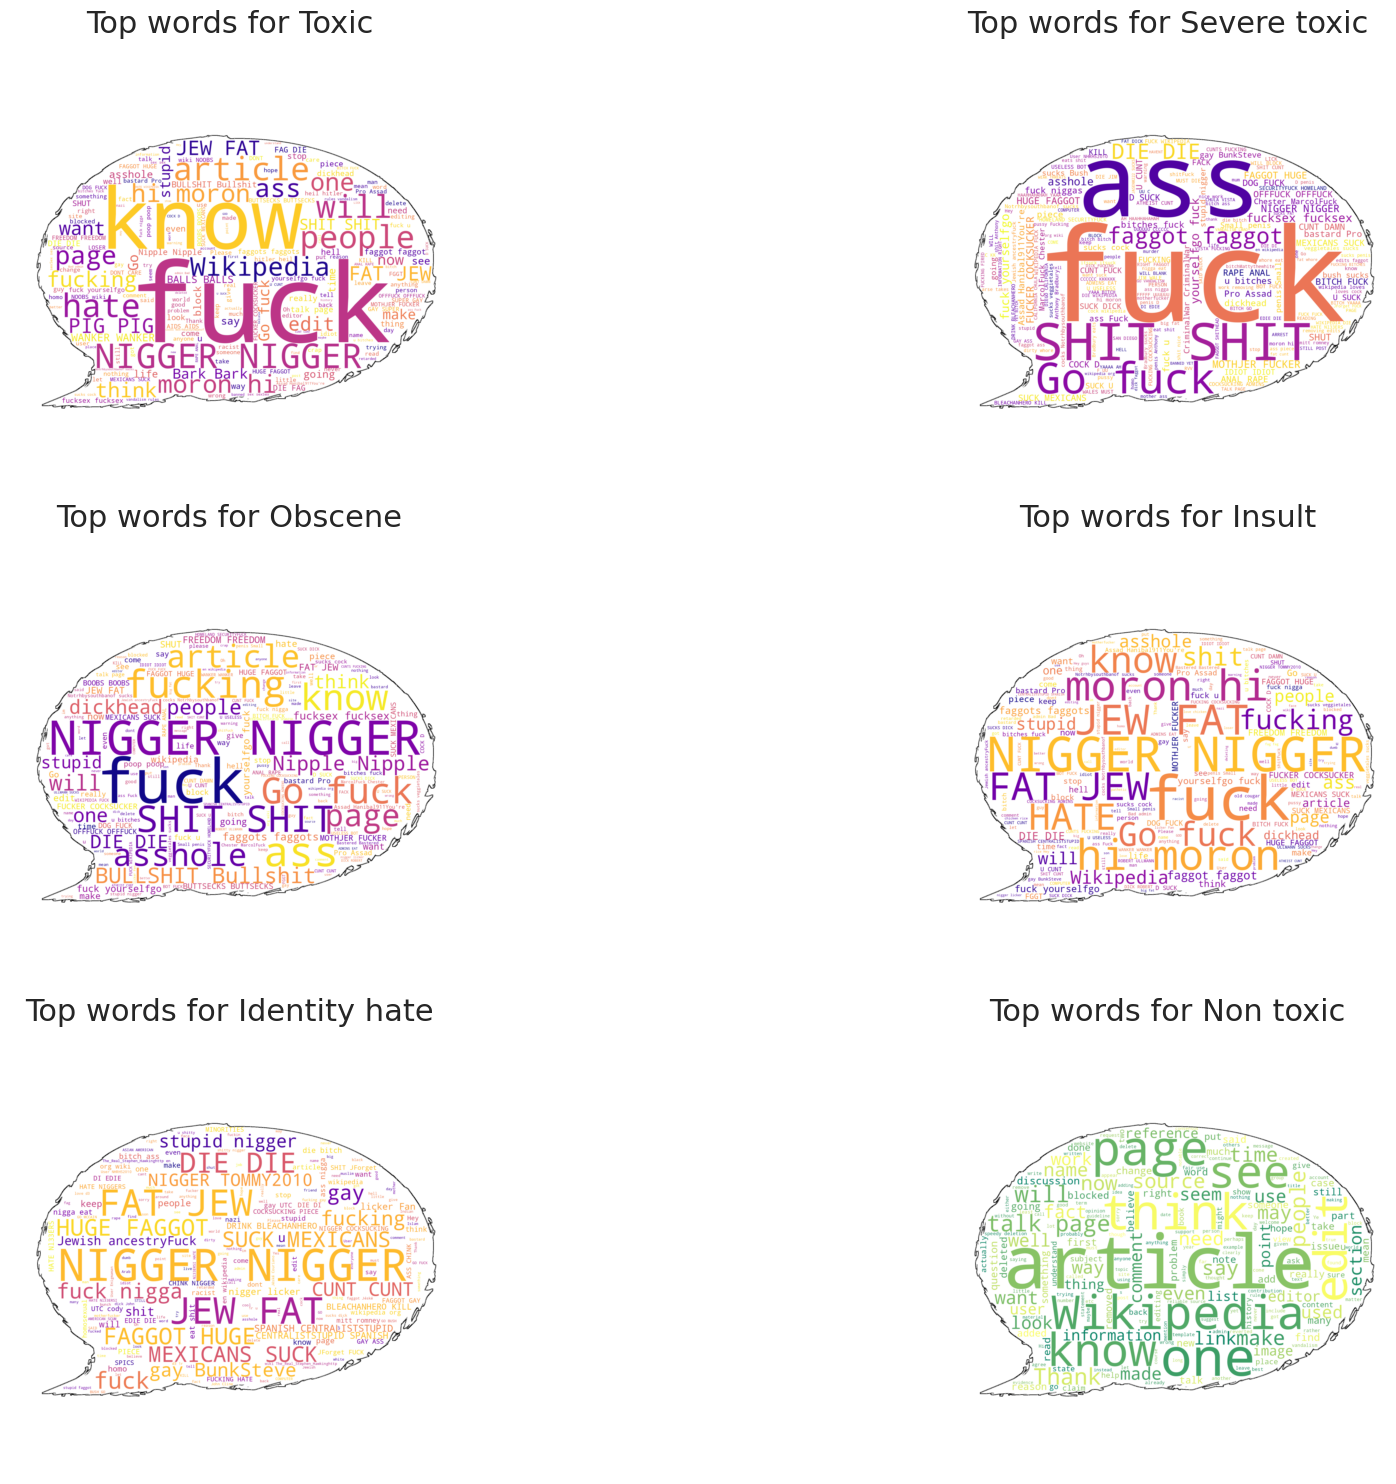

In [18]:
# Load the mask image
comment_mask = np.array(Image.open('Resources/comment.png'))

# Function to generate word cloud
def generate_wordcloud(text, title, ax, colormap):
    wc = WordCloud(
        background_color='white',
        max_words=200,
        mask=comment_mask,
        colormap=colormap, 
        contour_color='black',
        contour_width=1
    )
    wc.generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(title, fontdict={'size': 22, 'verticalalignment': 'bottom'})
    ax.axis('off')

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(24, 15))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Define the categories and their colormaps
categories = ['toxic', 'severe_toxic', 'obscene', 'insult', 'identity_hate', 'non_toxic']
dataframes = [toxic_df, severe_toxic_df, obscene_toxic_df, insult_df, identity_hate_df, non_toxic_df]
colormaps = {
    'toxic': 'plasma',  # Purple to red
    'severe_toxic': 'plasma',
    'obscene': 'plasma',
    'insult': 'plasma',
    'identity_hate': 'plasma',
    'non_toxic': 'summer'  # Green to yellow
}

# Generate word clouds for each category and add to subplots
for i, (category, df) in enumerate(zip(categories, dataframes)):
    text = ' '.join(df['comment_text'])
    colormap = colormaps.get(category, 'viridis')  # Default to 'viridis' if category not found
    generate_wordcloud(text, f'Top words for {category.replace("_", " ").capitalize()}', axes[i], colormap)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


<div style="background: #CBC3E3;padding:10px;border-radius:12px;border:1px solid #7d1b7e"><p>I'd prefer not to comment on these insights—mostly because they're filled with words that would make even a sailor blush 🙊💬


![Big Trouble If I Speak](https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExbm9mYXF5MnI4NGY4a2l5eTQ2eWo0ZXJ6OGd1aTNyd2ZyMjEwbHhpeiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/FXf1lYQ2tFouxeLb1B/giphy.gif)

<a id="4"></a>
# <p style="background-color:black; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">4 | Data Preparation</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="background: #CBC3E3;padding:10px;border-radius:12px;border:1px solid #7d1b7e"><p>From the visualizations, it is clear that all the target features fall under a common category. Therefore, I will consolidate all these targets into a single target labeled as '<b>toxic</b>'.

In [19]:
df = train.copy()

In [20]:
df['target'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)
df = df[['comment_text', 'target']]
df.head()

,comment_text,target
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


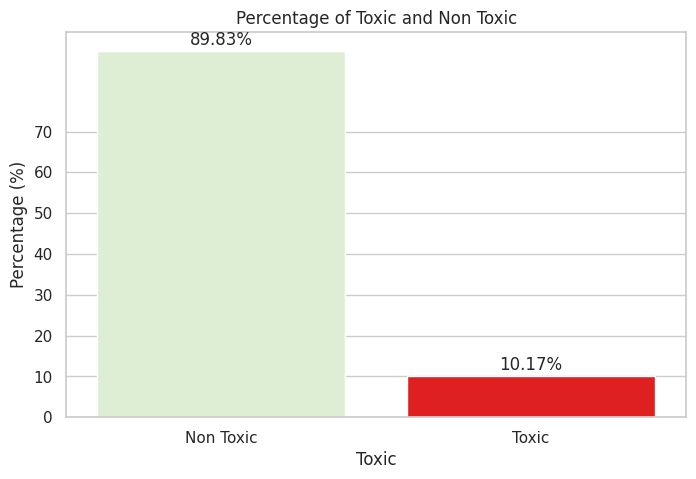

In [21]:
# Calculating the percentage of each class
percentage = df['target'].value_counts(normalize=True) * 100

# Define colors for the bars
colors = ['#DDF2D1' if x == 0 else 'red' for x in percentage.index]

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage, palette=colors)
plt.title('Percentage of Toxic and Non Toxic')
plt.xlabel('Toxic')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Non Toxic', 'Toxic'])
plt.yticks(ticks=range(0, 80, 10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()


<div style="background: #CBC3E3;padding:10px;border-radius:12px;border:1px solid #7d1b7e"><p>we can see the data is <b>imbalanced</b>, we will handle this in the subsequent steps

<a id="5"></a>
# <p style="background-color:black; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">5 | Train-Validation-Test Split</p>

⬆️ [Tabel of Contents](#contents_tabel)

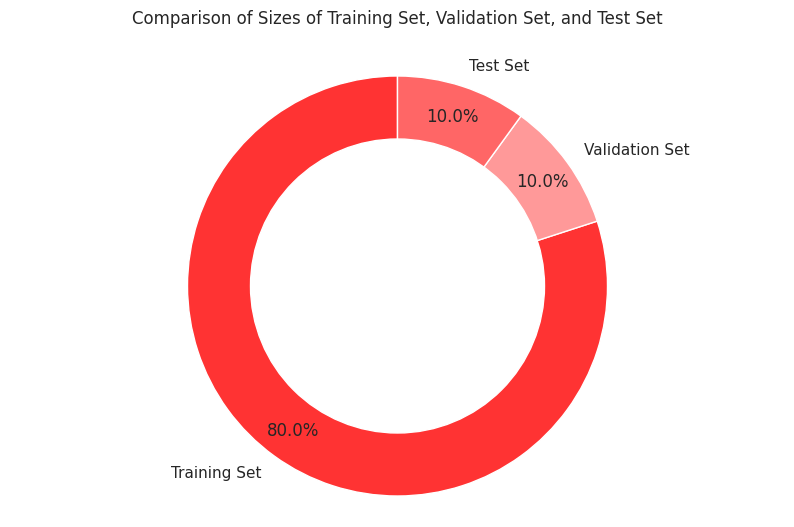

In [22]:
# Feature-target split
X = df['comment_text']
y = df['target']

# Train-test split (from complete data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
data_train = pd.concat([X_train, y_train], axis=1)

# Validation-test split (from test data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=121)
data_val, data_test = pd.concat([X_val, y_val], axis=1), pd.concat([X_test, y_test], axis=1)

# Comparison of sizes of training set, validation set, and test set
values = np.array([len(data_train), len(data_val), len(data_test)])
labels = ['Training Set', 'Validation Set', 'Test Set']

# Define shades of red
colors = ['#ff3333','#ff9999', '#ff6666']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, colors=colors)

# Draw a white circle at the center to create a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Add a title
plt.title('Comparison of Sizes of Training Set, Validation Set, and Test Set', y=1.05)

# Show the plot
plt.show()


<a id="6"></a>
# <p style="background-color:black; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">6 | Text Normalization</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [23]:
# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

<a id="6.1"></a>
# <b><span style='color:#7d1b7e'>6.1 |</span><span style='color:red'> Converting to Lowercase</span></b>

In [24]:
# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

text = "This is a FUNCTION that CoNvErTs a Text to lowercase"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))

Input: This is a FUNCTION that CoNvErTs a Text to lowercase
Output: this is a function that converts a text to lowercase


<a id="6.2"></a>
# <b><span style='color:#7d1b7e'>6.2 |</span><span style='color:red'> Removal of Whitespaces</span></b>

In [25]:
# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

text = " \t This is a string \t "
print("Input: {}".format(text))
print("Output: {}".format(remove_whitespace(text)))

Input:  	 This is a string 	 
Output: This is a string


<a id="6.3"></a>
# <b><span style='color:#7d1b7e'>6.3 |</span><span style='color:red'> Removal of Punctuations</span></b>

In [26]:
# Removing punctuations
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

text = "Here's [an] example? {of} &a string. with.? punctuations!!!!"
print("Input: {}".format(text))
print("Output: {}".format(remove_punctuation(text)))

Input: Here's [an] example? {of} &a string. with.? punctuations!!!!
Output: Here's an example of a string with punctuations


<a id="6.4"></a>
# <b><span style='color:#7d1b7e'>6.4 |</span><span style='color:red'> Handling of Unicode Characters</span></b>

In [27]:
# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

text = ' <a href = "https://www.kaggle.com/code/vishalnaik/intensity-classification"> Intensity classification </a>'
print("Input: {}".format(text))
print("Output: {}".format(remove_html(text)))

Input:  <a href = "https://www.kaggle.com/code/vishalnaik/intensity-classification"> Intensity classification </a>
Output:   Intensity classification 


In [28]:
"""
😊 - Smiling Face with Smiling Eyes
😂 - Face with Tears of Joy
😍 - Heart Eyes
😒 - Unamused Face
😢 - Crying Face
😎 - Smiling Face with Sunglasses
🙁 - Slightly Frowning Face
👍 - Thumbs Up
👏 - Clapping Hands
🙏 - Folded Hands
❤️ - Red Heart
🥺 - Pleading Face
🤔 - Thinking Face
🥳 - Partying Face
😔 - Pensive Face
😠 - Angry Face
🤗 - Hugging Face
😅 - Smiling Face with Sweat
😡 - Pouting Face
🤩 - Star-Struck
🙌 - Raising Hands
🔥 - Fire
💔 - Broken Heart
🎉 - Party Popper
💪 - Flexed Biceps

"""

# Define a mapping from emoji names to simplified descriptions
emoji_mapping = {
    'smiling_face_with_smiling_eyes': 'mocking',
    'face_with_tears_of_joy': 'sarcastic laugh',
    'heart_eyes': 'obsession',
    'crying_face': 'whining',
    'angry_face': 'rage',
    'enraged_face': 'fury',
    'thumbs_up': 'sarcastic approval',
    'clapping_hands': 'mocking applause',
    'red_heart': 'fake sympathy',
    'face_with_rolling_eyes': 'disdain',
    'face_with_symbols_on_mouth': 'cursing',
    'middle_finger': 'fuck off',
    # Add more mappings as needed
}

# Function to convert emojis to simplified text descriptions
def convert_emoji_to_text(text):
    # Convert emojis to detailed descriptions
    detailed_text = emoji.demojize(text, delimiters=(":", ":"))
    
    # Replace detailed descriptions with simplified ones
    for detailed, simplified in emoji_mapping.items():
        detailed_text = detailed_text.replace(f':{detailed}:', simplified + ' ')
    
    return detailed_text

text = "This innovative hd printing technique results in durable and spectacular looking prints 😊😂😡🖕❤️"
print("Input: {}".format(text))
print("Output: {}".format(convert_emoji_to_text(text)))


Input: This innovative hd printing technique results in durable and spectacular looking prints 😊😂😡🖕❤️
Output: This innovative hd printing technique results in durable and spectacular looking prints mocking sarcastic laugh fury fuck off fake sympathy 


In [29]:
# Removing other unicode characters
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

text = "It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols"
print("Input: {}".format(text))
print("Output: {}".format(remove_http(text)))

Input: It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols
Output: It's a function that removes links starting with http: or https such as 


<a id="6.5"></a>
# <b><span style='color:#7d1b7e'>6.5 |</span><span style='color:red'> Substitution of Acronyms</span></b>

In [30]:
acronyms_dict = {
    "aka": "also known as",
    "asap": "as soon as possible",
    "brb": "be right back",
    "btw": "by the way",
    "dob": "date of birth",
    "faq": "frequently asked questions",
    "fyi": "for your information",
    "idk": "i don't know",
    "idc": "i don't care",
    "iirc": "if i recall correctly",
    "imo": "in my opinion",
    "irl": "in real life",
    "lmk": "let me know",
    "lol": "laugh out loud",
    "ngl": "not gonna lie",
    "noyb": "none of your business",
    "nvm": "never mind",
    "ofc": "of course",
    "omg": "oh my god",
    "pfa": "please find attached",
    "rofl": "rolling on the floor laughing",
    "stfu": "shut the fuck up",
    "tba": "to be announced",
    "tbc": "to be continued",
    "tbd": "to be determined",
    "tbh": "to be honest",
    "ttyl": "talk to you later",
    "wtf": "what the fuck",
    "wth": "what the heck"
}
print("Example: Original form of the acronym 'fyi' is '{}'".format(acronyms_dict['fyi']))

Example: Original form of the acronym 'fyi' is 'for your information'


In [31]:
# List of acronyms
acronyms_list = list(acronyms_dict.keys())

# Function to convert contractions in a text
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "btw you've to fill in the details including dob"
print("Input: {}".format(text))
print("Output: {}".format(convert_acronyms(text)))

Input: btw you've to fill in the details including dob
Output: by the way you've to fill in the details including date of birth


<a id="6.6"></a>
# <b><span style='color:#7d1b7e'>6.6 |</span><span style='color:red'> Substitution of Contractions</span></b>

In [32]:
contractions_dict = {
    "'aight": "alright",
    "ain't": "are not",
    "amn't": "am not",
    "arencha": "are not you",
    "aren't": "are not",
    "'bout": "about",
    "can't": "cannot",
    "cap'n": "captain",
    "'cause": "because",
    "'cept": "except",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "dammit": "damn it",
    "daren't": "dare not",
    "daresn't": "dare not",
    "dasn't": "dare not",
    "didn't": "did not",
    "doesn't": "does not",
    "doin'": "doing",
    "don't": "do not",
    "dunno": "do not know",
    "d'ye": "do you",
    "e'en": "even",
    "e'er": "ever",
    "'em": "them",
    "everybody's": "everybody is",
    "everyone's": "everyone is",
    "fo'c'sle": "forecastle",
    "finna": "fixing to",
    "'gainst": "against",
    "g'day": "good day",
    "gimme": "give me",
    "giv'n": "given",
    "gonna": "going to",
    "gon't": "go not",
    "gotcha": "got you",
    "gotta": "got to",
    "gtg": "got to go",
    "hadn't": "had not",
    "had've": "had have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'll": "he shall",
    "helluva": "hell of a",
    "he's": "he is",
    "here's": "here is",
    "he've": "he have",
    "how'd": "how would",
    "howdy": "how do you do",
    "how'll": "how will",
    "how're": "how are",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i shall",
    "i'm": "i am",
    "imma": "i am about to",
    "i'm'a": "i am about to",
    "i'm'o": "i am going to",
    "innit": "is it not",
    "ion": "i do not",
    "i've": "i have",
    "i'd": "i had",
    "i'd've": "i would have",
    "i'll": "i shall",
    "i'm": "i am",
    "i'm'a": "i am about to",
    "i'm'o": "i am going to",
    "innit": "is it not",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it shall",
    "it's": "it is",
    "iunno": "i do not know",
    "kinda": "kind of",
    "let's": "let us",
    "li'l": "little",
    "ma'am": "madam",
    "mayn't": "may not",
    "may've": "may have",
    "methinks": "me thinks",
    "mightn't": "might not",
    "might've": "might have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "must've": "must have",
    "'neath": "beneath",
    "needn't": "need not",
    "nal": "and all",
    "ne'er": "never",
    "o'clock": "of the clock",
    "o'er": "over",
    "ol'": "old",
    "oughtn't": "ought not",
    "'round": "around",
    "'s": "is",
    "shalln't": "shall not",
    "shan't": "shall not",
    "she'd": "she had",
    "she'll": "she shall",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "somebody's": "somebody is",
    "someone's": "someone is",
    "something's": "something is",
    "so're": "so are",
    "so's": "so is",
    "so've": "so have",
    "that'll": "that shall",
    "that're": "that are",
    "that's": "that is",
    "that'd": "that would",
    "there'd": "there had",
    "there'll": "there shall",
    "there're": "there are",
    "there's": "there is",
    "these're": "these are",
    "these've": "these have",
    "they'd": "they had",
    "they'll": "they shall",
    "they're": "they are",
    "they've": "they have",
    "this's": "this is",
    "those're": "those are",
    "those've": "those have",
    "'thout": "without",
    "'til": "until",
    "'tis": "it is",
    "to've": "to have",
    "'twas": "it was",
    "'tween": "between",
    "'twhere": "it were",
    "wanna": "want to",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we shall",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "whatcha": "what are you",
    "what'd": "what did",
    "what'll": "what shall",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "where'd": "where did",
    "where'll": "where shall",
    "where're": "where are",
    "where's": "where is",
    "where've": "where have",
    "which'd": "which had",
    "which'll": "which shall",
    "which're": "which are",
    "which's": "which is",
    "which've": "which have",
    "who'd": "who would",
    "who'd've": "who would have",
    "who'll": "who shall",
    "who're": "who are",
    "who's": "who is",
    "who've": "who have",
    "why'd": "why did",
    "why're": "why are",
    "why's": "why is",
    "willn't": "will not",
    "won't": "will not",
    "wonnot": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd've": "you all would have",
    "y'all'd'n't've": "you all would not have",
    "y'all're": "you all are",
    "y'all'ren't": "you all are not",
    "y'at": "you at",
    "yes'm": "yes madam",
    "yessir": "yes sir",
    "you'd": "you had",
    "you'll": "you shall",
    "you're": "you are",
    "you've": "you have",
    "aight": "alright",
    "aint": "are not",
    "amnt": "am not",
    "arent": "are not",
    "cant": "cannot",
    "cause": "because",
    "couldve": "could have",
    "couldnt": "could not",
    "couldntve": "could not have",
    "darent": "dare not",
    "daresnt": "dare not",
    "dasnt": "dare not",
    "didnt": "did not",
    "doesnt": "does not",
    "doin": "doing",
    "dont": "do not",
    "eer": "ever",
    "everybodys": "everybody is",
    "everyones": "everyone is",
    "finna": "fixing to",
    "gday": "good day",
    "givn": "given",
    "gont": "go not",
    "hadnt": "had not",
    "hadve": "had have",
    "hasnt": "has not",
    "havent": "have not",
    "hed": "he had",
    "hell": "he shall",
    "hes": "he is",
    "heve": "he have",
    "howd": "how did",
    "howdy": "how do you do",
    "howll": "how will",
    "howre": "how are",
    "hows": "how is",
    "idve": "i would have",
    "ill": "i shall",
    "im": "i am",
    "ima": "i am about to",
    "imo": "i am going to",
    "innit": "is it not",
    "ive": "i have",
    "isnt": "is not",
    "itd": "it would",
    "itll": "it shall",
    "its": "it is",
    "lets": "let us",
    "lil": "little",
    "maam": "madam",
    "maynt": "may not",
    "mayve": "may have",
    "methinks": "me thinks",
    "mightnt": "might not",
    "mightve": "might have",
    "mustnt": "must not",
    "mustntve": "must not have",
    "mustve": "must have",
    "neednt": "need not",
    "neer": "never",
    "oclock": "of the clock",
    "oer": "over",
    "ol": "old",
    "oughtnt": "ought not",
    "shallnt": "shall not",
    "shant": "shall not",
    "shed": "she had",
    "shell": "she shall",
    "shes": "she is",
    "shouldve": "should have",
    "shouldnt": "should not",
    "shouldntve": "should not have",
    "somebodys": "somebody is",
    "someones": "someone is",
    "somethings": "something is",
    "thatll": "that shall",
    "thatre": "that are",
    "thatd": "that would",
    "thered": "there had",
    "therell": "there shall",
    "therere": "there are",
    "theres": "there is",
    "thesere": "these are",
    "theseve": "these have",
    "theyd": "they had",
    "theyll": "they shall",
    "theyre": "they are",
    "theyve": "they have",
    "thiss": "this is",
    "thosere": "those are",
    "thoseve": "those have",
    "tis": "it is",
    "tove": "to have",
    "twas": "it was",
    "wanna": "want to",
    "wasnt": "was not",
    "wed": "we had",
    "wedve": "we would have",
    "were": "we are",
    "weve": "we have",
    "werent": "were not",
    "whatd": "what did",
    "whatll": "what shall",
    "whatre": "what are",
    "whats": "what is",
    "whatve": "what have",
    "whens": "when is",
    "whered": "where did",
    "wherell": "where shall",
    "wherere": "where are",
    "wheres": "where is",
    "whereve": "where have",
    "whichd": "which had",
    "whichll": "which shall",
    "whichre": "which are",
    "whichs": "which is",
    "whichve": "which have",
    "whod": "who would",
    "whodve": "who would have",
    "wholl": "who shall",
    "whore": "who are",
    "whos": "who is",
    "whove": "who have",
    "whyd": "why did",
    "whyre": "why are",
    "whys": "why is",
    "wont": "will not",
    "wouldve": "would have",
    "wouldnt": "would not",
    "wouldntve": "would not have",
    "yall": "you all",
    "yalldve": "you all would have",
    "yallre": "you all are",
    "youd": "you had",
    "youll": "you shall",
    "youre": "you are",
    "youve": "you have",
    "'re": "are",
    "that's": "that is",
    "thats": "that is"
}

In [33]:
# List of contractions
contractions_list = list(contractions_dict.keys())

# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "it's function that make can't removes i'm"

print("Input: {}".format(text))
print("Output: {}".format(convert_contractions(text)))

Input: it's function that make can't removes i'm
Output: it is function that make cannot removes i am


<a id="6.7"></a>
# <b><span style='color:#7d1b7e'>6.7 |</span><span style='color:red'> Slangs and Abbreviations Handling</span></b>

In [34]:
abbreviations = {
    "$" : "dollar",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired",
    "lol" : "laugh out loud",
    "lit": "exciting",
    "btw":"by the way",
}



In [36]:
nltk.download('punkt_tab')

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [abbreviations[word.lower()] if word.lower() in abbreviations else word for word in tokens]
    text = ' '.join(tokens)
    return text

text = "w/o lol, that party was so lit last night! BTW, did you see how many people were taking selfies?"
print("Input: {}".format(text))
print("Output: {}".format(convert_abbrev_in_text(text)))

Input: w/o lol, that party was so lit last night! BTW, did you see how many people were taking selfies?
Output: without laugh out loud , that party was so exciting last night ! by the way , did you see how many people were taking selfies ?


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


<a id="6.8"></a>
# <b><span style='color:#7d1b7e'>6.8 |</span><span style='color:red'> Spelling Correction</span></b>

In [37]:
# pyspellchecker
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

text = "I'm goinng therre"
print("Input: {}".format(text))
print("Output: {}".format(pyspellchecker(text)))

Input: I'm goinng therre
Output: I'm going there


<a id="6.9"></a>
# <b><span style='color:#7d1b7e'>6.9 |</span><span style='color:red'> Stemming and Lemmatization</span></b>

<div style="background: #CBC3E3;padding:10px;border-radius:12px;border:1px solid #7d1b7e"> 
    
[**Stemming**](https://en.wikipedia.org/wiki/Stemming) is the process of reducing the words to their root form or **stem**. It reduces related words to the same *stem* even if the stem is not a dictionary word. For example, the words **introducing**, **introduced**, **introduction** reduce to a common word **introduce**. However, the process often produces stems that are not actual words.

In [38]:
# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_stemmer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduc lemmat as an improv over stem


<div style="background: #CBC3E3;padding:10px;border-radius:12px;border:1px solid #7d1b7e">   
    
The stems **introduc**, **lemmat** and **improv** are not actual words. [**Lemmatization**](https://en.wikipedia.org/wiki/Lemmatisation) offers a more sophisticated approach by utilizing a corpus to match root forms of the words. Unlike stemming, it uses the context in which a word is being used.

In [42]:
# Lemmatization

spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_lemmatizer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduce lemmatization as an improvement over stem


<a id="6.10"></a>
# <b><span style='color:#7d1b7e'>6.10 |</span><span style='color:red'> Discardment of Non-alphabetic Words</span></b>

In [43]:
# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

text = "It is an ocean of thousands and 1000s of crowd"
print("Input: {}".format(text))
print("Output: {}".format(discard_non_alpha(text)))

Input: It is an ocean of thousands and 1000s of crowd
Output: It is an ocean of thousands and of crowd


<a id="6.11"></a>
# <b><span style='color:#7d1b7e'>6.11 |</span><span style='color:red'> Retainment of Relevant Parts of Speech</span></b>

<div style="background: #CBC3E3;padding:10px;border-radius:12px;border:1px solid #7d1b7e"> 
    
Utilizing [**parts of speech**](https://en.wikipedia.org/wiki/Part_of_speech)  is an effective strategy to identify and retain words that are most likely to be relevant for classification tasks while filtering out less important ones to minimize noise. The approach involves selecting specific parts of speech that are pertinent to the problem's context. By categorizing the words in a text into various subsets based on their parts of speech, we can then retain only those subsets that correspond to the chosen parts of speech.
    
[**pos_tags list**](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

In [45]:
nltk.download('averaged_perceptron_tagger_eng')

def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    #keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW']
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'PRP', 'PRPS','JJ',
                 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP','WP$',
                 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']

    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

text = "I’M sorry If I Change But You Changed Too"
print("Input: {}".format(text))
tokens = regexp.tokenize(text)
print("Tokens: {}".format(tokens))
tokens_tagged = nltk.pos_tag(tokens)
print("Tagged Tokens: {}".format(tokens_tagged))
print("Output: {}".format(keep_pos(text)))

Input: I’M sorry If I Change But You Changed Too
Tokens: ['I', 'M', 'sorry', 'If', 'I', 'Change', 'But', 'You', 'Changed', 'Too']
Tagged Tokens: [('I', 'PRP'), ('M', 'VBP'), ('sorry', 'JJ'), ('If', 'IN'), ('I', 'PRP'), ('Change', 'VBP'), ('But', 'CC'), ('You', 'PRP'), ('Changed', 'VBD'), ('Too', 'NNP')]
Output: I M sorry I Change You Changed Too


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


<a id="6.12"></a>
# <b><span style='color:#7d1b7e'>6.12 |</span><span style='color:red'> Stop-words Removal</span></b>

In [46]:
nltk.download('stopwords')
stops = stopwords.words("english") # stopwords
alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
all_stops =  stops + alphabets


print(all_stops)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [47]:
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in all_stops])

text = "i am sad. i got fail in one subject, wait i will share you on whatsapp"
print("Input: {}".format(text))
print("Output: {}".format(remove_stopwords(text)))

Input: i am sad. i got fail in one subject, wait i will share you on whatsapp
Output: sad got fail one subject wait share whatsapp


<a id="6.13"></a>
# <b><span style='color:#7d1b7e'>6.13 |</span><span style='color:red'> Workflow Integration</span></b>

In [48]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub(r'\.com\b', '', text) # Remove ".com"
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = convert_emoji_to_text(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = convert_abbrev_in_text(text)
#     text = pyspellchecker(text)
    text = text_lemmatizer(text) # text = text_stemmer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = convert_to_lowercase(text)
    text = remove_stopwords(text)

    return text

text = """'I’M sorry 😡🖕❤️ If I Change But You Changed Too. & We'll [#* combine all ] {functions <into 1> SINGLE 1000 FUNCTION  & apply  on @product #content make
 removes  https://en.wikipedia.org/wiki/Text_normalization"""


print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))

Input: 'I’M sorry 😡🖕❤️ If I Change But You Changed Too. & We'll [#* combine all ] {functions <into 1> SINGLE 1000 FUNCTION  & apply  on @product #content make
 removes  https://en.wikipedia.org/wiki/Text_normalization
Output: sorry fury fuck fake sympathy change change combine function single function apply product content make remove


In [49]:
# Implementing text normalization
data_train_norm, data_val_norm, data_test_norm = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

data_train_norm['normalized_comment_text'] = data_train['comment_text'].apply(text_normalizer)
data_val_norm['normalized_comment_text'] = data_val['comment_text'].apply(text_normalizer)
data_test_norm['normalized_comment_text'] = data_test['comment_text'].apply(text_normalizer)

data_train_norm['target'] = data_train['target']
data_val_norm['target'] = data_val['target']
data_test_norm['target'] = data_test['target']

data_train_norm['normalized_comment_text']

157279           hmmm work polish proffesor reliable source
1259                                                   talk
1562      duel unit costsi remove duel unit cost figure ...
95532     okay let settle thislook section title peter g...
104452     ask explain point view edit summary correct talk
                                ...                        
97639     actual research possibility character power wo...
95939              insult first fair warn well call justice
152315                 page need go away good riddance talk
117952    useful template many usacentric article find w...
43567     british empirethe british empire appear strong...
Name: normalized_comment_text, Length: 127656, dtype: object

In [ ]:
# data_train_norm.to_csv("data_train_norm.csv", index=False)
# data_test_norm.to_csv("data_test_norm.csv", index=False)
# data_val_norm.to_csv("ddata_val_norm.csv", index=False)

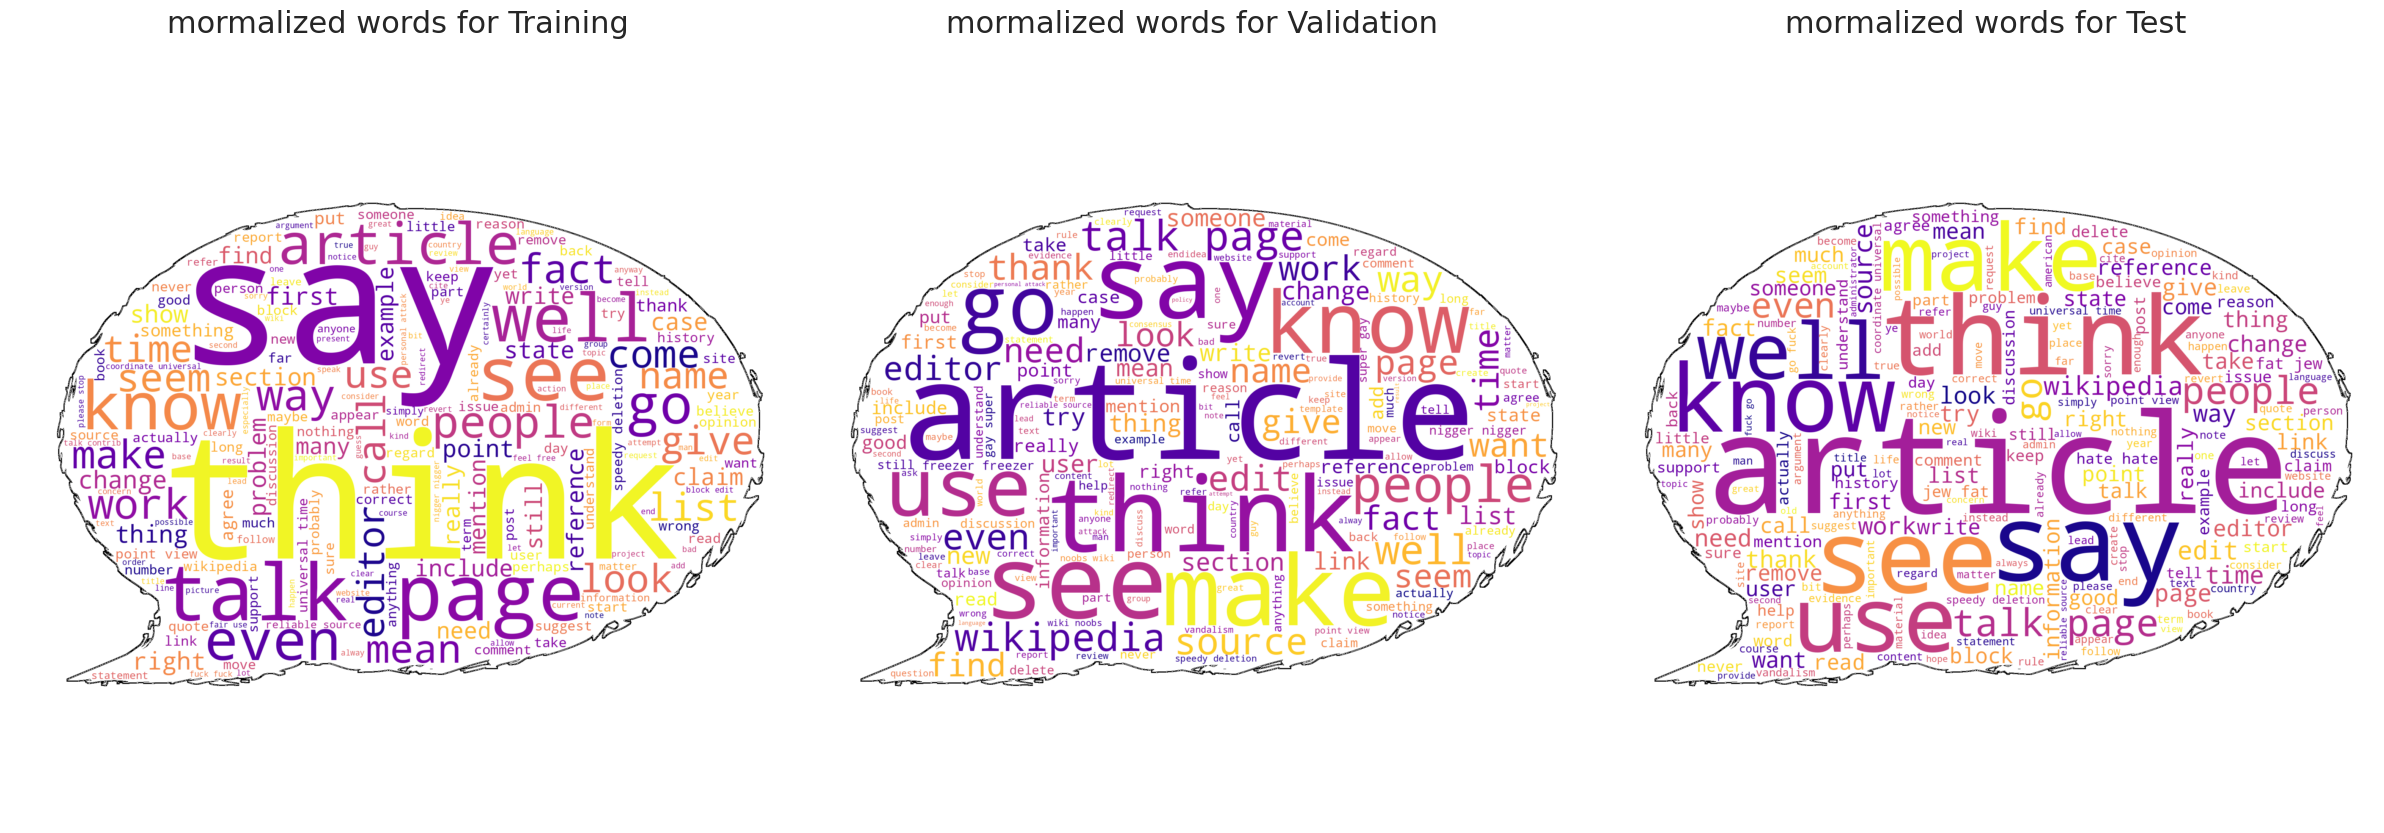

In [50]:
# Load the mask image
comment_mask = np.array(Image.open('Resources/comment.png'))

# Function to generate word cloud
def generate_wordcloud(text, title, ax):
    wc = WordCloud(
        background_color='white',
        max_words=200,
        mask=comment_mask,
        colormap='plasma', 
        contour_color='black',
        contour_width=1
    )
    wc.generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(title, fontdict={'size': 22, 'verticalalignment': 'bottom'})
    ax.axis('off')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 20))

# Define the categories and corresponding datasets
categories = ['Training', 'Validation', 'Test']
datasets = [data_train_norm, data_val_norm, data_test_norm]

# Generate word clouds for each category and add to subplots
for i, (category, dataset) in enumerate(zip(categories, datasets)):
    text = " ".join(description for description in dataset['normalized_comment_text'])
    generate_wordcloud(text, f'mormalized words for {category.capitalize()}', axes[i])

# Adjust layout and show plot
plt.tight_layout()
plt.show()


<a id="7"></a>
# <p style="background-color:black; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">7 | TF-IDF Vectorization</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [51]:
# Features and labels
X_train_norm, y_train = data_train_norm['normalized_comment_text'].tolist(), data_train_norm['target'].tolist()
X_val_norm, y_val = data_val_norm['normalized_comment_text'].tolist(), data_val_norm['target'].tolist()
X_test_norm, y_test = data_test_norm['normalized_comment_text'].tolist(), data_test_norm['target'].tolist()

In [52]:
# TF-IDF vectorization
# TfidfVec = TfidfVectorizer()
TfidfVec = TfidfVectorizer(ngram_range = (1, 2),max_features=400) # using both unigram & bi-grams

X_train_tfidf = TfidfVec.fit_transform(X_train_norm)
X_val_tfidf = TfidfVec.transform(X_val_norm)
X_test_tfidf = TfidfVec.transform(X_test_norm)

<a id="8"></a>
# <p style="background-color:black; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">8 | Model Building</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [53]:
# Classifiers
names = [
    "ComplementNB",
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
]

models = [
    ComplementNB(),
    LogisticRegression(max_iter = 1000,class_weight= 'balanced'),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(class_weight= 'balanced'),
    svm.SVC(kernel = 'linear', class_weight= 'balanced'),
    RandomForestClassifier(n_estimators = 100, class_weight= 'balanced'),
    SGDClassifier(loss = 'hinge',class_weight= 'balanced'),
    RidgeClassifier(class_weight= 'balanced'),
]


<div style="background: #CBC3E3;padding:10px;border-radius:12px;border:1px solid #7d1b7e"> 
    <h2>🎯 Note:</h2>

In this toxic content classification problem, the target variable is the toxicity label, which indicates whether a comment is toxic (1) or non-toxic (0). Both false positives (predicting a comment as toxic when it is not) and false negatives (predicting a comment as non-toxic when it is toxic) can have significant implications.

However, false negatives may be more critical because missing toxic comments could lead to harmful content being overlooked and potentially spreading. Therefore, it is important to minimize false negatives, which means maximizing recall for the 'toxic' class (1) should be a priority.

Precision is also important because it minimizes false positives, meaning fewer cases where the model incorrectly labels non-toxic comments as toxic. This is crucial to avoid unnecessarily censoring benign content and frustrating users.

Thus, the F1-score, which balances both precision and recall, would be a good metric to use. Specifically, <b>the F1-score for the 'toxic' class (1) would be the most important metric for evaluating models in this project>/b>, ensuring that the model effectively identifies toxic content while minimizing false alarms.

In [54]:
# Function to return summary of baseline models
def score(X_train, y_train, X_test, y_test, X_val, y_val, names=names, models=models):
    score_df = pd.DataFrame()
    score_train, score_test, score_val = [], [], []

    for model in models:
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_val_pred = model.predict(X_val)

        score_train.append(f1_score(y_train, y_train_pred, average='weighted'))
        score_test.append(f1_score(y_test, y_test_pred, average='weighted'))
        score_val.append(f1_score(y_val, y_val_pred, average='weighted'))

    score_df["Classifier"] = names
    score_df["Training F1-score"] = score_train
    score_df["Test F1-score"] = score_test
    score_df["Validation F1-score"] = score_val

    score_df.sort_values(by='Validation F1-score', ascending=False, inplace=True)
    return score_df


In [55]:
# Summary of baseline models
score(X_train_tfidf, y_train,X_test_tfidf, y_test, X_val_tfidf, y_val, names = names, models = models)

,Classifier,Training F1-score,Test F1-score,Validation F1-score
2,KNN Classifier,0.901500,0.896677,0.901231
5,Random Forest,0.952408,0.895509,0.898589
3,Decision Tree,0.948688,0.863757,0.865150
0,ComplementNB,0.859517,0.860270,0.852635
1,Logistic Regression,0.843623,0.842929,0.838213
6,SGD Classifier,0.838438,0.837810,0.832636
4,Linear SVM,0.835197,0.834582,0.830199
7,Ridge Classifier,0.834026,0.833036,0.827876


<a id="9"></a>
# <p style="background-color:black; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">9 | Model Evaluation</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [56]:
def evaluate_model(model, X_train, y_train, X_test, y_test, X_val=None, y_val=None):
    # Evaluate the model on the train data
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, model.predict(X_train), target_names=['Non-toxic', 'toxic']))

    # Evaluate the model on the test data
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, model.predict(X_test), target_names=['Non-toxic', 'toxic']))

    if X_val is not None and y_val is not None:
        # Evaluate the model on the validation data
        print("\n\t   Classification report for validation set")
        print("-"*55)
        print(classification_report(y_val, model.predict(X_val), target_names=['Non-toxic', 'toxic']))

    # Generate confusion matrix for test data
    cm = confusion_matrix(y_test, model.predict(X_test))

    # Define the class labels
    class_labels = ['Non-toxic', 'toxic']

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix - Test Set')

    # Plot ROC curve for each class on the test data
    plt.subplot(1, 2, 2)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_test, model.predict_proba(X_test)[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Test Set')
    plt.legend(loc='lower right')
    plt.tight_layout()

    plt.show()

    if X_val is not None and y_val is not None:
        # Generate confusion matrix for validation data
        cm_val = confusion_matrix(y_val, model.predict(X_val))

        # Plot the confusion matrix as a heatmap
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title('Confusion Matrix - Validation Set')

        # Plot ROC curve for each class on the validation data
        plt.subplot(1, 2, 2)
        fpr_val = {}
        tpr_val = {}
        roc_auc_val = {}
        for i in range(len(class_labels)):
            fpr_val[i], tpr_val[i], _ = roc_curve(y_val, model.predict_proba(X_val)[:, i], pos_label=i)
            roc_auc_val[i] = auc(fpr_val[i], tpr_val[i])
            plt.plot(fpr_val[i], tpr_val[i], lw=2, label=f'{class_labels[i]} (AUC = {roc_auc_val[i]:0.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Validation Set')
        plt.legend(loc='lower right')
        plt.tight_layout()

        plt.show()


In [63]:
rf = RandomForestClassifier(n_estimators = 100, class_weight= 'balanced')
rf_model = rf.fit(X_train_tfidf, y_train)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

   Non-toxic       1.00      0.94      0.97    114736
       toxic       0.67      0.98      0.79     12920

    accuracy                           0.95    127656
   macro avg       0.83      0.96      0.88    127656
weighted avg       0.96      0.95      0.95    127656


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

   Non-toxic       0.95      0.93      0.94     14289
       toxic       0.49      0.53      0.51      1669

    accuracy                           0.89     15958
   macro avg       0.72      0.73      0.73     15958
weighted avg       0.90      0.89      0.89     15958


	   Classification report for validation set
-------------------------------------------------------
              precision    recall  f1-score   sup

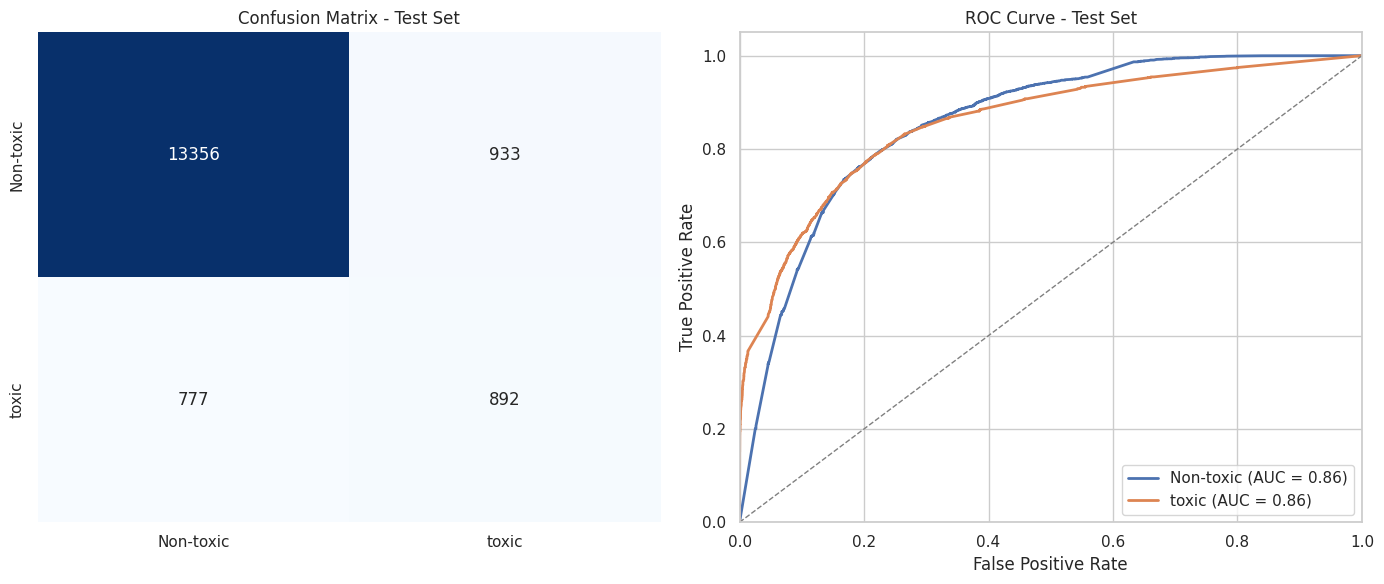

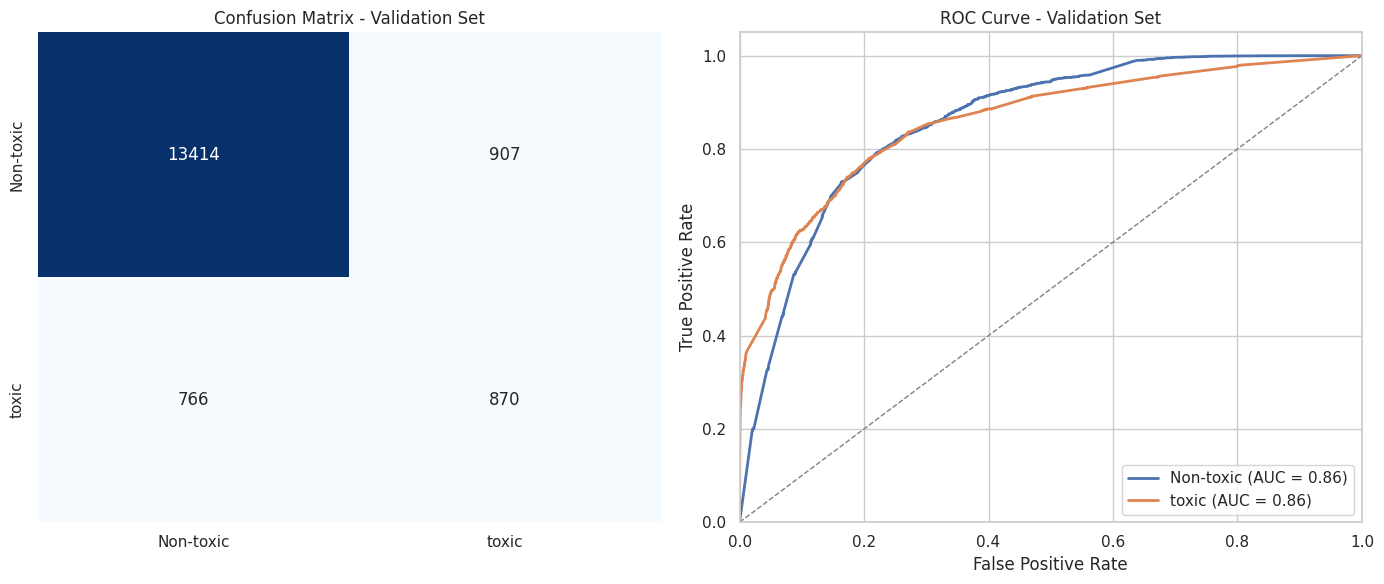

In [64]:
evaluate_model(rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test, X_val_tfidf, y_val)

<div style="background: #CBC3E3;padding:10px;border-radius:12px;border:1px solid #7d1b7e"> 

  <h2>Inference:</h2>
  <p>Our model's performance across different datasets is summarized as follows:</p>
  
  <p><strong>Training Set:</strong></p>
  <ul>
    <li><strong>Accuracy:</strong> 95%, indicating the model correctly predicts the class labels 95% of the time.</li>
    <li><strong>Non-toxic Class:</strong> Precision is 100%, and Recall is 94%, resulting in an F1-score of 97%. This shows that the model is very good at predicting non-toxic instances with minimal false positives.</li>
    <li><strong>Toxic Class:</strong> Precision is 67%, and Recall is 98%, leading to an F1-score of 79%. The model is highly sensitive to toxic instances but tends to misclassify non-toxic instances as toxic.</li>
  </ul>

  <p><strong>Test Set:</strong></p>
  <ul>
    <li><strong>Accuracy:</strong> 89%, which suggests the model is generally accurate on unseen data.</li>
    <li><strong>Non-toxic Class:</strong> Precision is 95%, and Recall is 93%, yielding an F1-score of 94%, indicating strong performance in predicting non-toxic instances.</li>
    <li><strong>Toxic Class:</strong> Precision is 49%, and Recall is 53%, with an F1-score of 51%, showing that the model struggles with identifying toxic instances, resulting in many false positives and false negatives.</li>
  </ul>

  <p><strong>Validation Set:</strong></p>
  <ul>
    <li><strong>Accuracy:</strong> 90%, showing consistent performance with the test set.</li>
    <li><strong>Non-toxic Class:</strong> Precision and Recall are both around 94%, with an F1-score of 94%, consistent with the test set performance.</li>
    <li><strong>Toxic Class:</strong> Precision is 49%, and Recall is 53%, with an F1-score of 51%, again showing difficulty in accurately classifying toxic instances.</li>
  </ul>

  <p>Overall, the model performs well in predicting non-toxic instances, but there is significant room for improvement in identifying toxic cases. The consistent performance across test and validation sets suggests that the model is not overfitting, but further tuning or data balancing might be required to enhance its effectiveness in predicting toxic instances.</p>
</div>


<a id="10"></a>
# <p style="background-color:black; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">10 | Testing on NEW Data</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [65]:
test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [66]:
test_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [68]:
filtered_test_labels = test_labels[(test_labels != -1).all(axis=1)]

In [71]:
test_df = pd.merge(test, filtered_test_labels, on='id', how='inner')
test_df['target'] = (test_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)
test_df = test_df[['comment_text', 'target']]
test_df.head()

,comment_text,target
0,Thank you for understanding. I think very high...,0
1,:Dear god this site is horrible.,0
2,"""::: Somebody will invariably try to add Relig...",0
3,""" \n\n It says it right there that it IS a typ...",0
4,""" \n\n == Before adding a new product to the l...",0


In [72]:
test_df['target'].value_counts()

target
0    57735
1     6243
Name: count, dtype: int64

In [74]:
# Implementing text normalization
data_new_norm = pd.DataFrame()

data_new_norm['normalized_comment_text'] = test_df['comment_text'].apply(text_normalizer)
data_new_norm['target'] = test_df['target']
X_new_norm, y_new = data_new_norm['normalized_comment_text'].tolist(), data_new_norm['target'].tolist()

In [75]:
# TF-IDF vectorization
X_new_tfidf = TfidfVec.transform(X_new_norm)

In [76]:
y_new_predict = rf_model.predict(X_new_tfidf)

In [77]:
# Calculate accuracy
accuracy = accuracy_score(y_new, y_new_predict)

print(f"New Data Accuracy using RF Model: {accuracy:.4f}")

New Data Accuracy using RF Model: 0.8458
